In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
import cv2
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import networkx as nx

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase
from omnilearn import viz as viz_util

from sklearn.decomposition import PCA
import sklearn.datasets

from src import sample_full_interventions, response_mat, factor_reponses
from src.responses import sample_full_interventions

# import gpumap
from c3linearize import linearize, class_graph


In [17]:
device = 'cuda'
figure_root = Path('figures/responses')
figure_root = None
if figure_root is not None and not figure_root.exists():
    figure_root.mkdir()
seed = 10
B = 128
N = 16
G = 32

In [3]:
dataset = fig.quick_run('load-data', name='3dshapes', mode='full', labeled=True, shuffle=False, seed=seed)
# dataset = fig.quick_run('load-data', name='full-mpi3d', labeled=True, shuffle=False, sort=True)
# images = dataset.images
# labels = dataset.labels
# images.shape, labels.shape
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > num_workers: 0 (by default)
|  > batch_size: 64 (by default)
|  > shuffle: False
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: '3dshapes'
|  > _dataset_mod: [] (by default)
|  > default_mode --> mode: 'full'
|  > mode-aliases: {} (by default)
|  > seed: 10
|  > din: None (by default)
|  > dout: None (by default)
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 10
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/3dshapes)
|  >  > mode: 'full'
|  >  > labeled: True
|  >  > label_type: 'class' (by default)
|  >  > din: (3, 64, 64) (by default)
|  >  > dout: 6 (by default)
|  >  >

480000

In [4]:
batch = dataset.get_batch(shuffle=True)
X, Y = batch
X.shape, Y.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 6]))

In [5]:
factors = dataset.get_factor_order()
factor_sizes = dataset.get_factor_sizes()
factors, factor_sizes

(['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation'],
 [10, 10, 10, 8, 4, 15])

In [6]:
sampler = InterventionSamplerBase(dataset)
interventions = sample_full_interventions(sampler, num_groups=20, pbar=tqdm)

  0%|          | 0/6 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


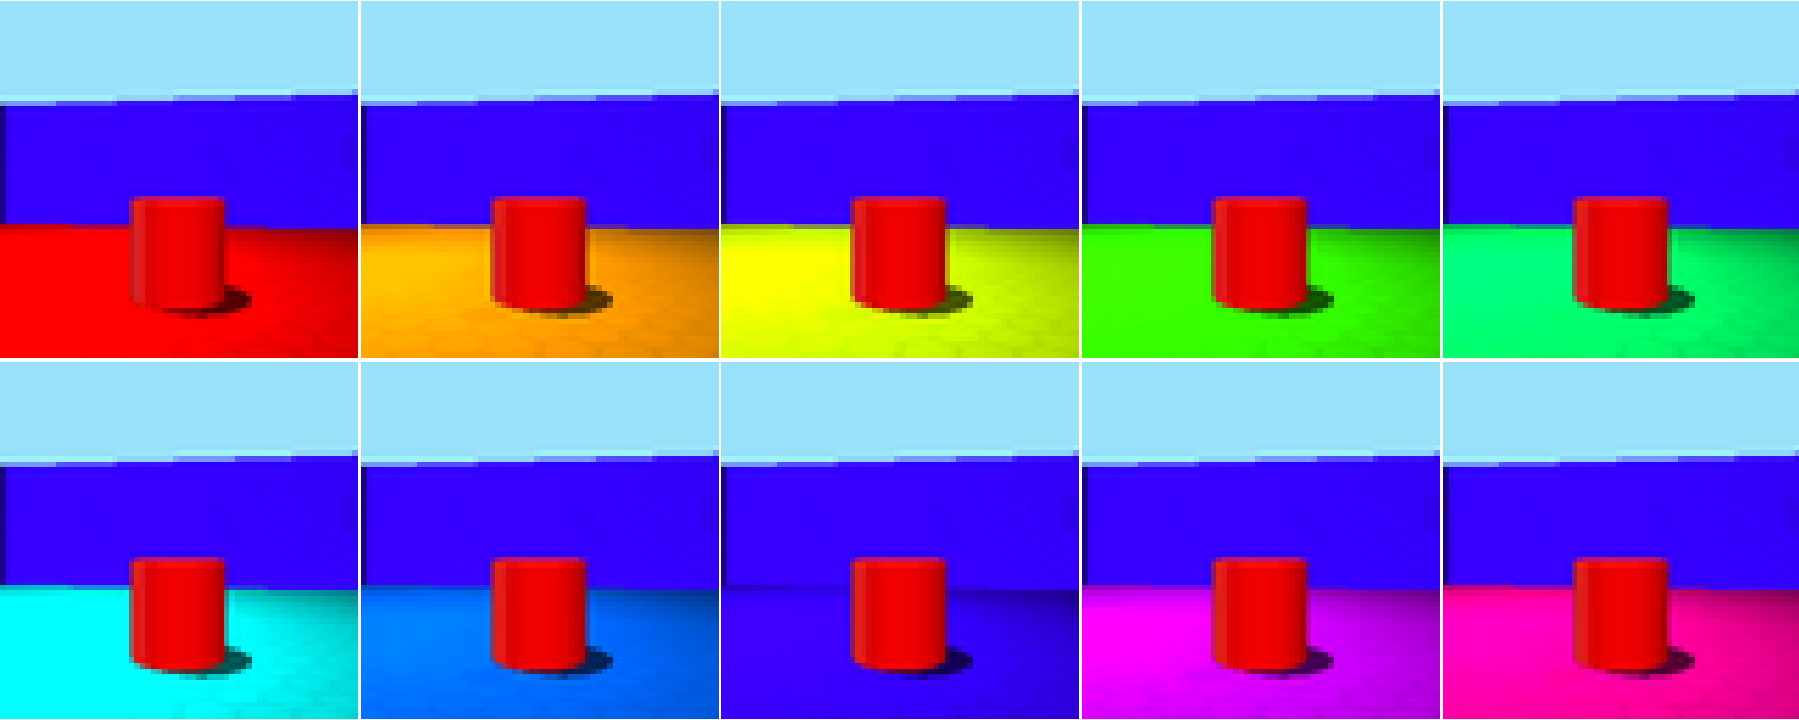

In [13]:
intervention_dim = 0
intervention_imgs = sampler.full_intervention(intervention_dim)
imgs = intervention_imgs
util.plot_imgs(imgs);

In [115]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\trained_nets')
# root = Path(r'C:\Users\anwan\Documents\workspace\trained_nets')
run_names = os.listdir(str(root))
len(run_names)

238

In [116]:
print(tabulate(enumerate(run_names)))

---  -------------------------------------------------
  0  3ds_ae0_e-c12_d-c12_210125-045343
  1  3ds_ae0_e-c12_d-c12_coord_210125-045521
  2  3ds_ae0_e-c12_d-c12_mish_210125-050038
  3  3ds_ae0_e-c12_d-c12_res-nn_210125-045937
  4  3ds_ae0_e-c12_d-c12_res_210125-045520
  5  3ds_ae0_e-c12_d-s12_210125-045438
  6  3ds_ae0_e-c12_d-s12_coord_210125-050236
  7  3ds_ae0_e-c12_d-s12_mish_210125-050335
  8  3ds_ae0_e-c12_d-s12_nosplit_210125-045438
  9  3ds_ae0_e-c12_d-s12_res-nn_210125-050336
 10  3ds_ae0_e-c12_d-s12_res_210125-050235
 11  3ds_ae0_e-c12_d-s2_210125-132645
 12  3ds_ae0_e-c12_d-s2_nosplit_210125-134343
 13  3ds_ae0_e-c12_d-s3_210125-134123
 14  3ds_ae0_e-c12_d-s3_nosplit_210125-134835
 15  3ds_ae0_e-c12_d-s4_210125-045438
 16  3ds_ae0_e-c12_d-s4_mish_210125-140253
 17  3ds_ae0_e-c12_d-s4_nosplit_210125-045440
 18  3ds_ae0_e-c12_d-s4_seed2_210125-133117
 19  3ds_ae0_e-c12_d-s6_210125-045438
 20  3ds_ae0_e-c12_d-s6_lrp0003_210125-171518
 21  3ds_ae0_e-c12_d-s6_lrp0004_210125-17

In [117]:
# run_name = run_names[7] # s12 mish
# run_name = run_names[5] # s12
# run_name = random.choice(run_names)
# run_name = run_names[0] # ae conv
# run_name = run_names[49]
run_name = run_names[29]
run_name = run_names[56]

# run_name = run_names[32]

# run_name = '3ds_vae2_e-c12_d-c12_210125-045344'
# run_name = '3ds_vae1_e-l12_d-l12_210125-045439'
# run_name = '3ds_vae16_e-c12_d-c12_210125-045345'

# run_name = short[0]

# run_name = '3ds_vae4_d-conv_b4-d24_210411-165936'
run_name

'3ds_wae100_e-c12_d-c12_210125-221143'

In [118]:
load_config = fig.get_config(path=run_name, root=str(root), **{'override.device':device})
load_config.set_silent(True)
run = fig.run('load-run', load_config)

In [119]:
A = run.get_config()
A.set_silent(True)
info = A.pull('info')
info

{'arch_type': 'c12',
 'dataset_type': '3ds',
 'dec_type': 'c12',
 'enc_type': 'c12',
 'model_type': 'wae',
 'size': 64}

In [120]:
if figure_root is not None:
    figure_dir = figure_root / run_name
    if not figure_dir.exists():
        figure_dir.mkdir()
else:
    figure_dir = None
model = run.get_model()
model.switch_to('val')
model.to(device);

Hybrid_Gaussian_WAE(
  (encoder): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

In [121]:
# dataset = run.get_dataset()
# dataset.switch_to('val')
# len(dataset)

In [122]:
# if R is None:
#     with torch.no_grad():
#         R, Q = model(X, ret_q=True)
#         if isinstance(Q, distrib.Distribution):
#             Q = Q.loc

In [123]:
# util.plot_imgs(X[:N])
# plt.suptitle('Original')
# plt.subplots_adjust(top=0.95)
# util.plot_imgs(R[:N])
# plt.suptitle('Reconstructions')
# plt.subplots_adjust(top=0.95)
# pass

In [124]:
fullQ = []
total = 10000
bs = 100
loader = dataset.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    batch = next(loader)
    x = model._process_batch(batch).original
    with torch.no_grad():
        q = model.encode(x)
        if isinstance(q, distrib.Distribution):
            q = q.loc
        fullQ.append(q)
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
fullQ.shape

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 12])

In [125]:
scales = fullQ.std(0)
# scales = None

<IPython.core.display.Javascript object>


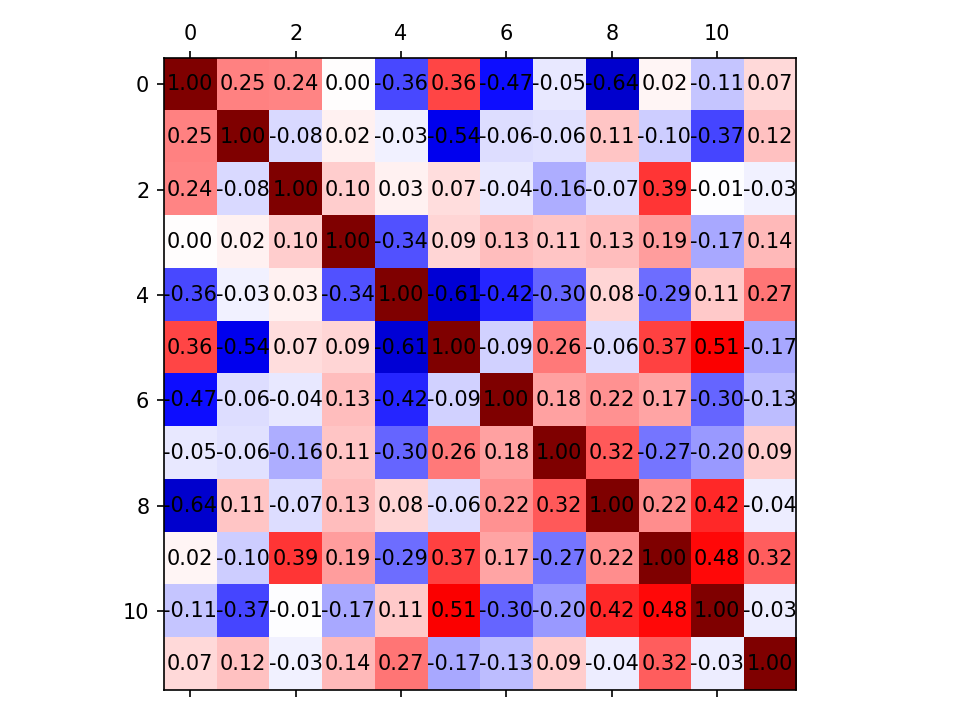

In [126]:
C = np.cov(fullQ.div(scales).cpu().t().numpy())
util.plot_mat(C, val_fmt=2, cmap='seismic', vmin=-1, vmax=1)
plt.tight_layout()
# util.save_figure(f'{run_name}_cov', root=figure_dir)
util.save_figure(f'cov', root=figure_dir)

In [127]:
R = response_mat(fullQ[:100], model.encode, model.decode, scales=scales, dist_type='rms', force_different=True)

<IPython.core.display.Javascript object>


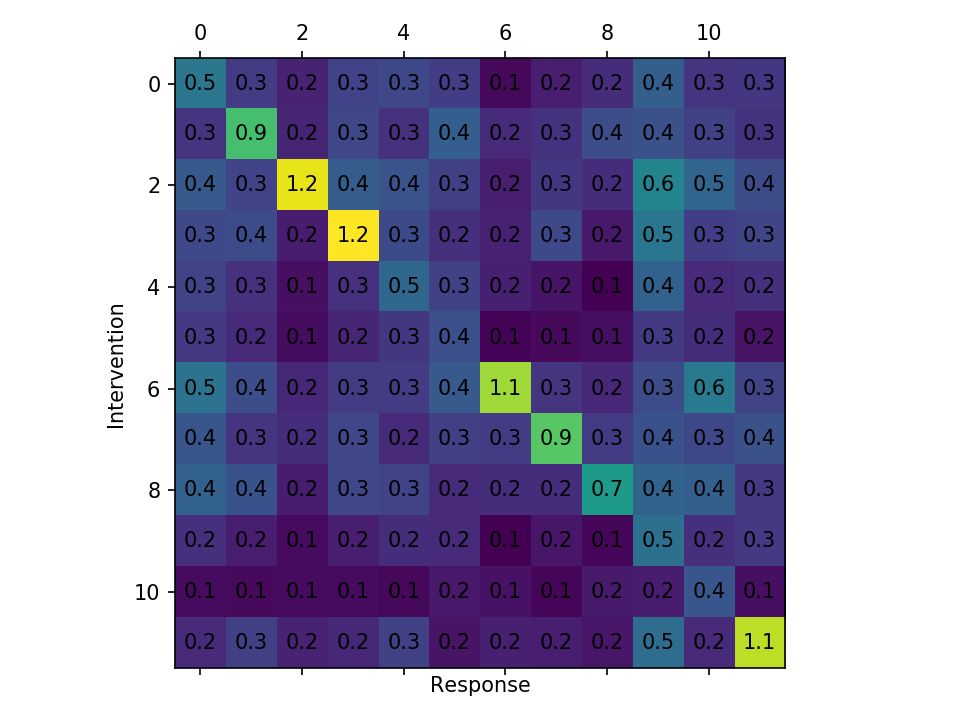

In [128]:
util.plot_mat(R, val_fmt=1) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.tight_layout()
# util.save_figure(f'{run_name}_full_responses', root=figure_dir)
util.save_figure(f'full_responses', root=figure_dir)

In [129]:
# # epsilon interventions
# mags = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
# frames = []
# for mag in tqdm(mags):
#     Rm = response_mat(fullQ[:100], model.encode, model.decode, scales=scales, mag=mag, dist_type='rms', force_different=True)
#     fg, _ = util.plot_mat(Rm, val_fmt=1) # responses
#     plt.ylabel('Intervention')
#     plt.xlabel('Response')
#     plt.tight_layout()
#     frame = util.fig_to_rgba(fg)
#     plt.close(fg)
#     frames.append(frame)
# frames = np.stack(frames)
# frames.shape

In [130]:
# mov = util.Video(frames)
# if figure_dir is not None:
#     path = figure_dir / f'seq{bidx}.mp4'
# #     path = figure_dir / f'{run.name}_seq{bidx}.mp4'
#     mov.export(path)
#     print(f'Movie saved: {str(path)}')
# mov.play('jupyter', scale=1, fps=5)

In [131]:
sel = torch.arange(len(R))[R.diag() > 0.4]
sel

tensor([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 11])

<IPython.core.display.Javascript object>


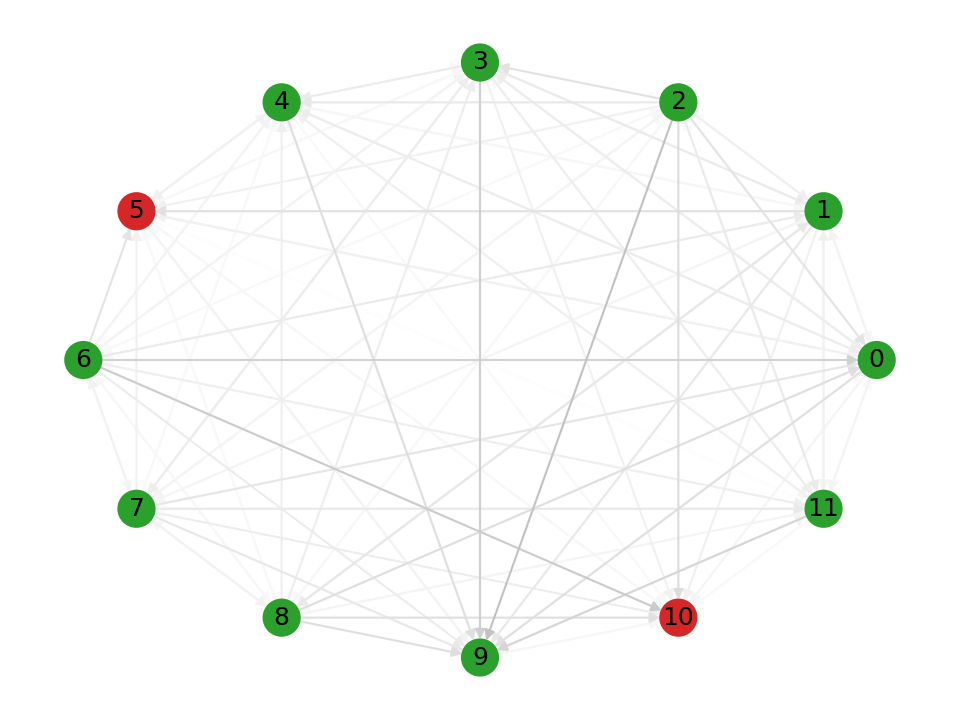

In [132]:
G = nx.from_numpy_matrix(R.cpu().pow(2).numpy(), create_using=nx.MultiDiGraph)

colors = 'C1'
colors = ['C2' if i in sel else 'C3' for i in range(len(G))]

edges,weights = zip(*sorted(nx.get_edge_attributes(G,'weight').items(), key=lambda x: x[-1], reverse=False))

try:
    pos = nx.planar_layout(G)
except:
#     pos = nx.spring_layout(G)
    pos = nx.circular_layout(G)

kwargs = dict(pos=pos, node_color=colors, with_labels=True,
              edgelist=edges, edge_color=weights,
              edge_cmap=plt.get_cmap('binary'), vmin=0)
plt.figure()
nx.draw(G, **kwargs)
# util.save_figure(f'{run_name}_graph', root=figure_dir)
util.save_figure(f'graph', root=figure_dir)

<IPython.core.display.Javascript object>


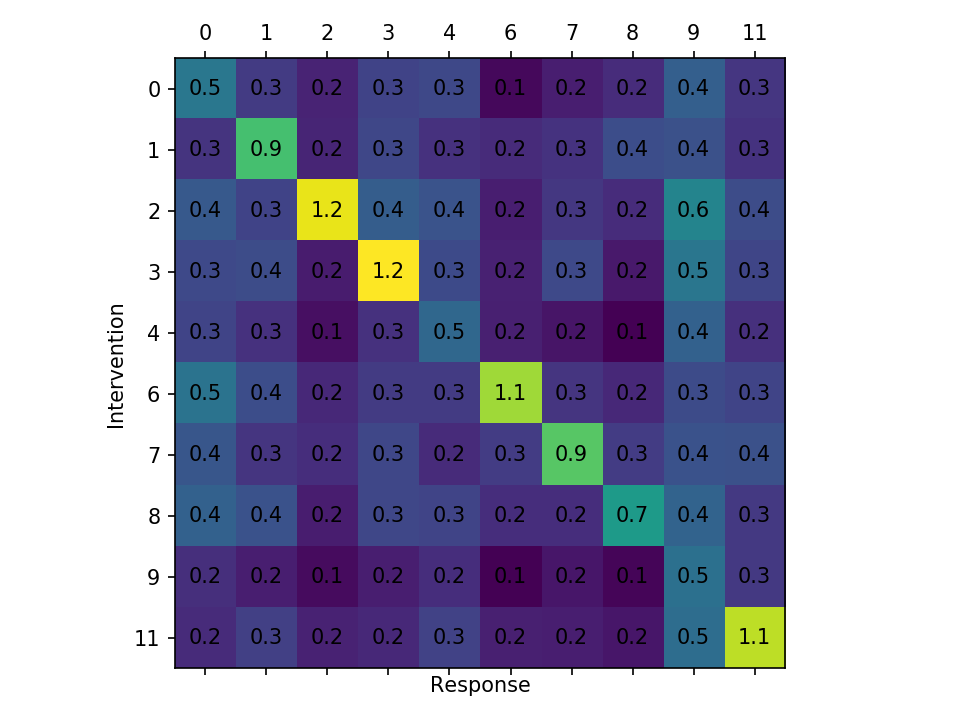

In [133]:
util.plot_mat(R[sel][:,sel], val_fmt=1) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.tight_layout()
# util.save_figure(f'{run_name}_sel_responses', root=figure_dir)
util.save_figure(f'sel_responses', root=figure_dir)

<IPython.core.display.Javascript object>


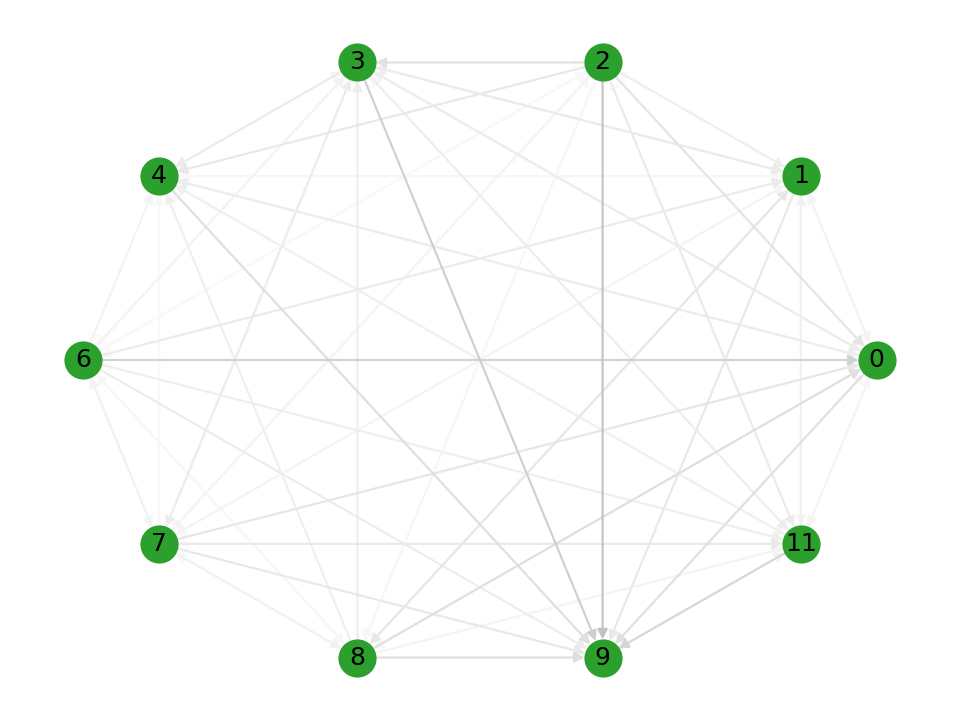

In [134]:
G = nx.from_numpy_matrix(R[sel][:,sel].cpu().pow(2).numpy(), create_using=nx.MultiDiGraph)

colors = 'C2'
# colors = ['C2' if i in sel else 'C3' for i in range(len(G))]

edges,weights = zip(*sorted(nx.get_edge_attributes(G,'weight').items(), key=lambda x: x[-1], reverse=False))

try:
    pos = nx.planar_layout(G)
except:
#     pos = nx.spring_layout(G)
    pos = nx.circular_layout(G)

kwargs = dict(pos=pos, node_color=colors, labels={i:str(n.item()) for i,n in enumerate(sel)},#, with_labels=True,
              edgelist=edges, edge_color=weights,
              edge_cmap=plt.get_cmap('binary'), vmin=0)
plt.figure()
nx.draw(G, **kwargs)
# util.save_figure(f'{run_name}_graph', root=figure_dir)
util.save_figure(f'sel-graph', root=figure_dir)

In [135]:
mats, lts = factor_reponses(model.encode, model.decode, interventions, pbar=tqdm, include_q=True, 
                       resp_kwargs=dict(scales=scales,force_different=True))
# W = mats.mean(-1).mean(1)

M = mats.min(1)[0].max(-1)[0]
# M = mats.mean(1).max(-1)[0]

mats.shape, len(lts), M.shape

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(torch.Size([6, 20, 12, 12]), 6, torch.Size([6, 12]))

<IPython.core.display.Javascript object>


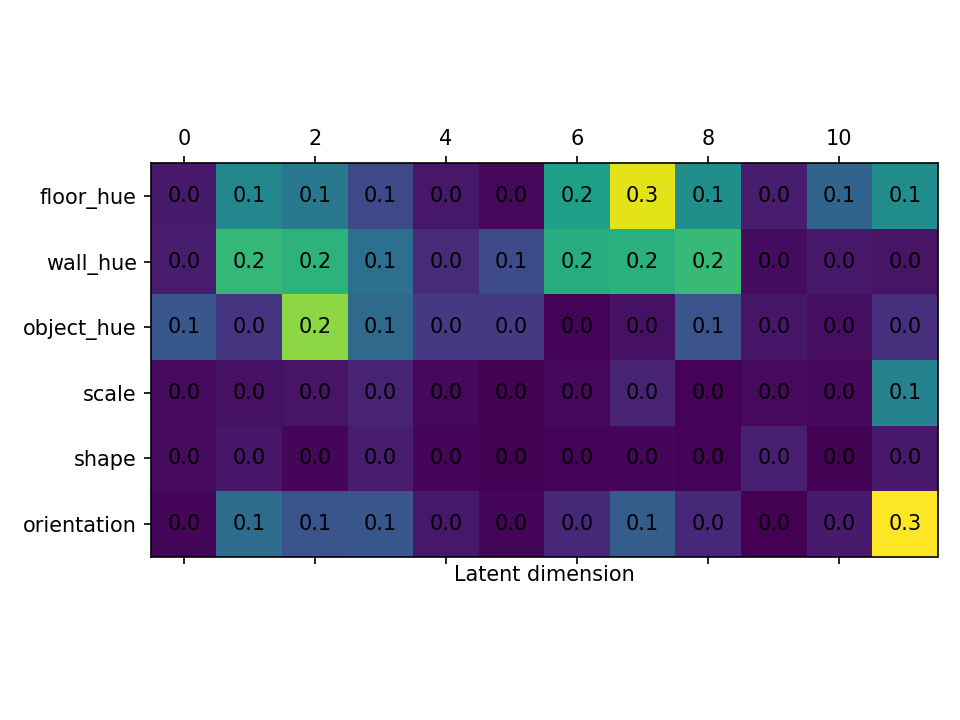

In [136]:
util.plot_mat(M, val_fmt=1)
plt.yticks(range(len(factors)), factors)
plt.xlabel('Latent dimension')
plt.tight_layout()
# util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
util.save_figure(f'factor-responses', root=figure_dir)
pass # an intervention on which latent dimension responds the most given that the intervention can 
#      only change the given factor of variation

In [143]:
full = interventions[3][1]
with torch.no_grad():
    fq = model.encode(full.to(device))
    if isinstance(fq, distrib.Normal):
        fq = fq.mean

<IPython.core.display.Javascript object>


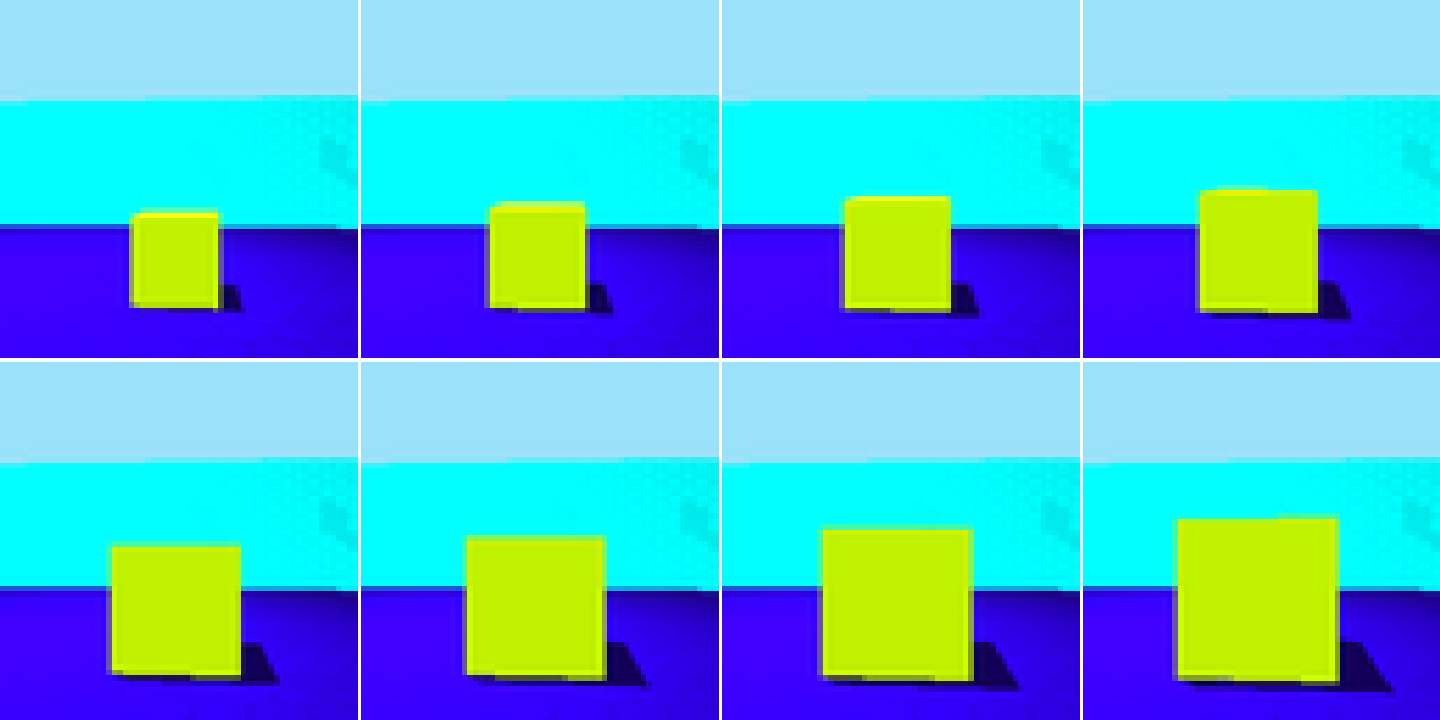

<IPython.core.display.Javascript object>


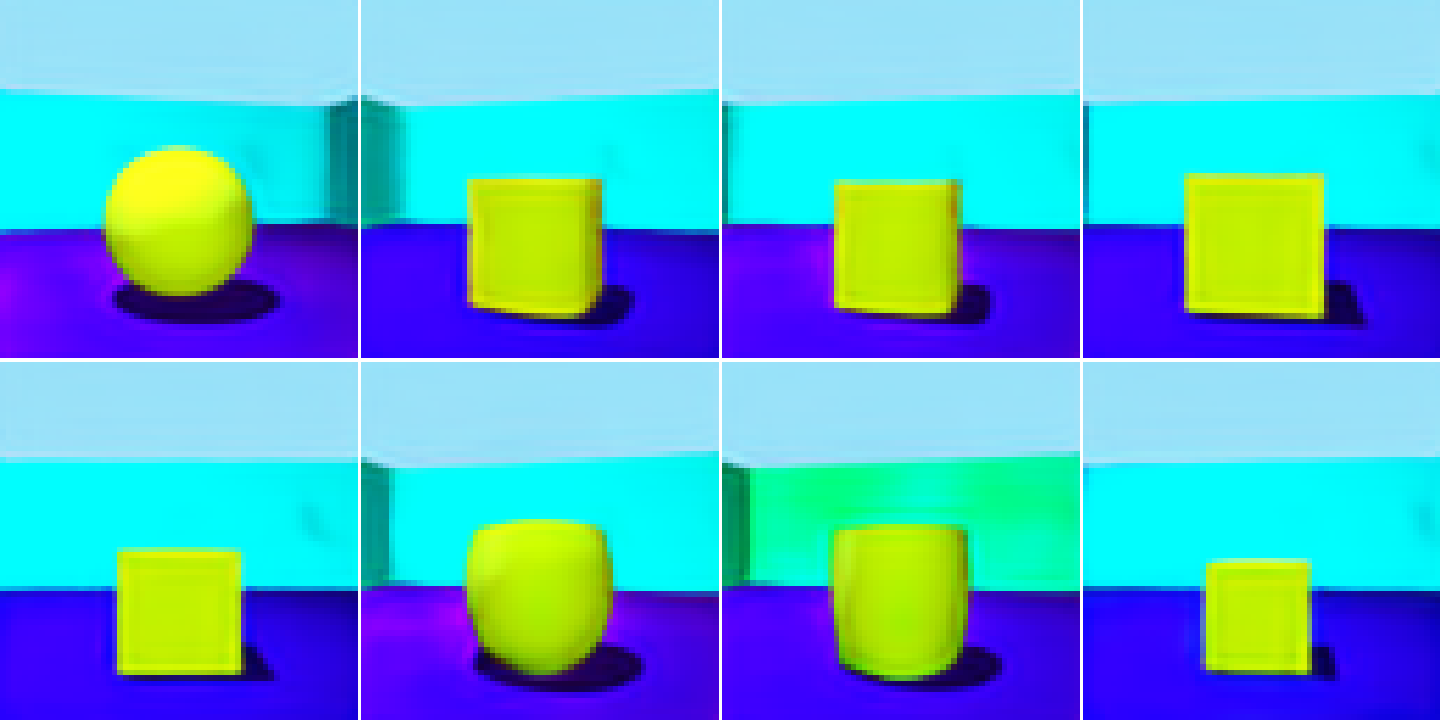

In [146]:
with torch.no_grad():
    hq = model.hybridize(fq)
    vim = model.decode(hq.to(device))
util.plot_imgs(full);
util.plot_imgs(vim);

In [109]:
bidx = 0

In [110]:
with torch.no_grad():
    Q = model.encode(X.to(device))
    if isinstance(Q, distrib.Normal):
        Q = Q.mean
q = Q[bidx]
Q.shape, q.shape

(torch.Size([64, 24]), torch.Size([24]))

In [111]:
n = 16
steps = 40
# info.steps = 20
# info.steps = 7
# info.steps = 5
ntrav = 1
stretch = 0.1

In [112]:
rg = Q.max(0)[0] - Q.min(0)[0]
rg = rg.unsqueeze(-1)
vecs = viz_util.get_traversal_vecs(q.unsqueeze(0), steps=steps,
          mnmx=(Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg)).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# vecs.shape
walks = viz_util.get_traversals(vecs, model.decode, device=device).cpu()
# diffs = viz_util.compute_diffs(walks)
walks.shape

torch.Size([1, 24, 40, 3, 64, 64])

In [113]:
tH, tW = 4,3
if info['dec_type'] == 's6':
    tH, tW = 6,2
if info['dec_type'] == 's3':
    tH, tW = 3,4

if walks.size(1) != tH*tW:
    tH, tW = util.calc_tiling(walks.size(1))
    
tH, tW

(4, 6)

In [114]:
full = walks

# tH, tW = util.calc_tiling(full.size(1), prefer_tall=True)
B, N, S, C, H, W = full.shape


full = full.view(B, tH, tW, S, C, H, W)
# print(full.shape)
full = full.squeeze(0).permute(2,0,4,1,5,3).contiguous()
frames = full.view(S, tH*H, tW*W, C).mul(255).byte().numpy()



frames.shape
# full = full.permute(0,1,2,5,3,6,4).contiguous().view(B, run.tH, run.tW*H, S*W, C).squeeze(0)

(40, 256, 384, 3)

In [115]:

font                   = cv2.FONT_HERSHEY_SIMPLEX
font                   = cv2.FONT_HERSHEY_COMPLEX
fontScale              = 0.5
fontColor              = (0,0,0)
lineType               = 1

px, py = 2, 12

for frame in frames:
    for i,j in np.ndindex(tH, tW):
        idx = i*tW+j
        cv2.putText(frame, f'{idx}', 
            (px+H*j, py+W*i), 
            font, 
            fontScale,
            fontColor,
            lineType)


Movie saved: figures\responses\3ds_vae4_d-conv_b4-d24_210411-165936\seq0.mp4


<IPython.core.display.Javascript object>


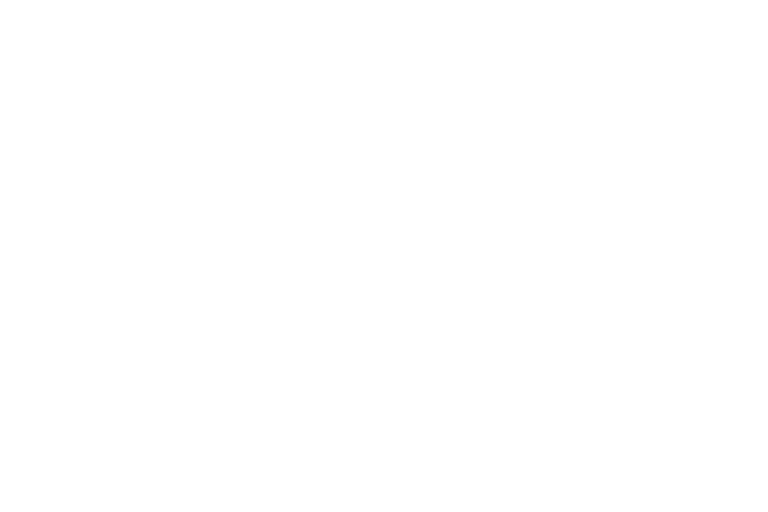

In [116]:
mov = util.Video(frames)
if figure_dir is not None:
    path = figure_dir / f'seq{bidx}.mp4'
#     path = figure_dir / f'{run.name}_seq{bidx}.mp4'
    mov.export(path)
    print(f'Movie saved: {str(path)}')
mov.play('jupyter', scale=2)

<IPython.core.display.Javascript object>


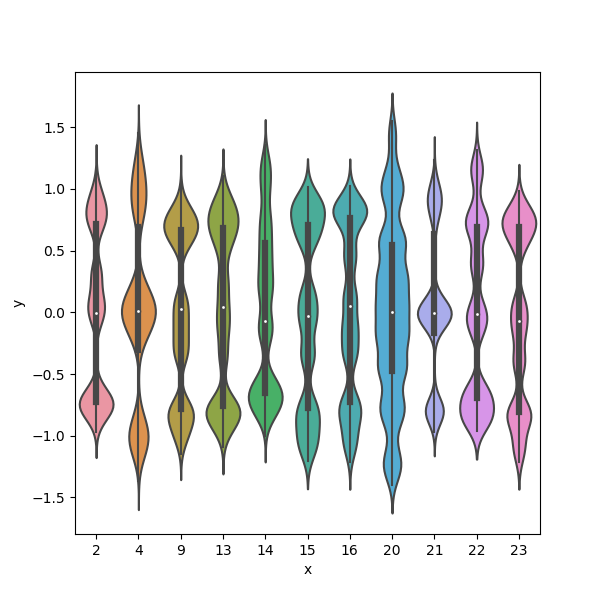

Figure latent_marginals saved as {'png'}


In [117]:
util.plot_distribs(fullQ.t()[sel].cpu());
plt.xticks(np.arange(len(sel)),sel.tolist());
util.save_figure(f'latent_marginals', root=figure_dir);

<IPython.core.display.Javascript object>


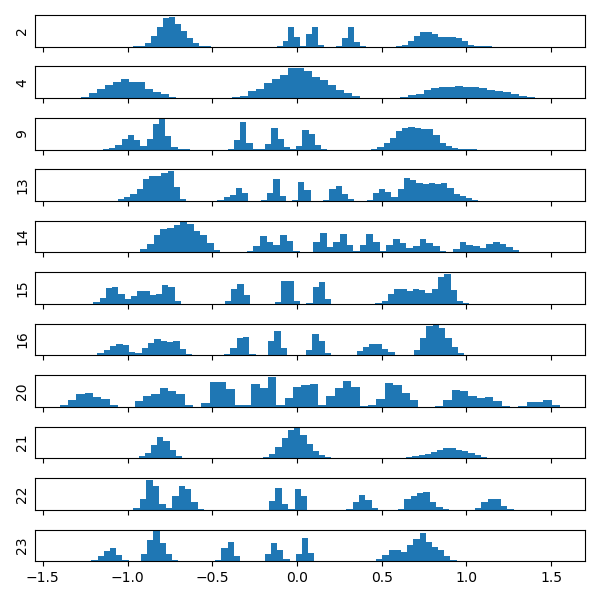

Figure latent_hists saved as {'png'}


In [118]:
pts = fullQ.cpu().t()[sel]
fg, axs = util.plot_hists(pts, bins=60, sharex=True);
for ax, s in zip(axs, sel.tolist()):
    plt.sca(ax)
    plt.ylabel(str(s))
#     plt.xticks([])
    plt.yticks([])
plt.tight_layout()
util.save_figure(f'latent_hists', root=figure_dir);

In [119]:

factor_dim = 5

# ix, iy = 3, 4
# ix, iy = 9, 10

ix, iy = None, None
ix, iy = 13, 14

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


<IPython.core.display.Javascript object>


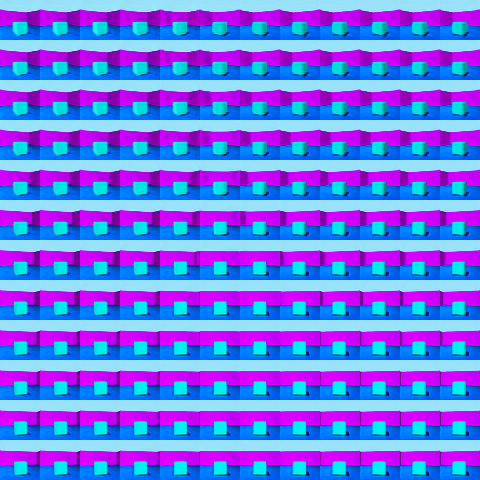

Figure 2D_traversal_13_14 saved as {'png'}


<IPython.core.display.Javascript object>


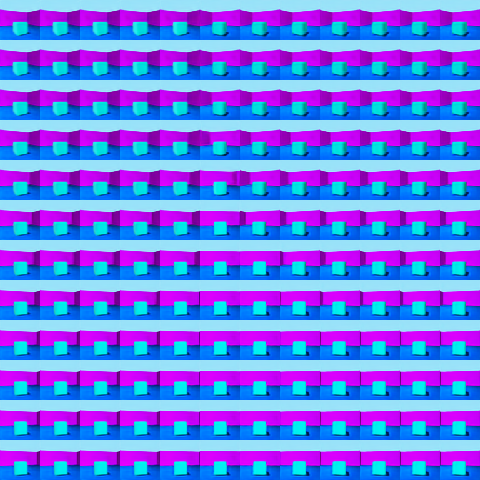

Figure 2D_traversal_recovery_13_14 saved as {'png'}


<IPython.core.display.Javascript object>


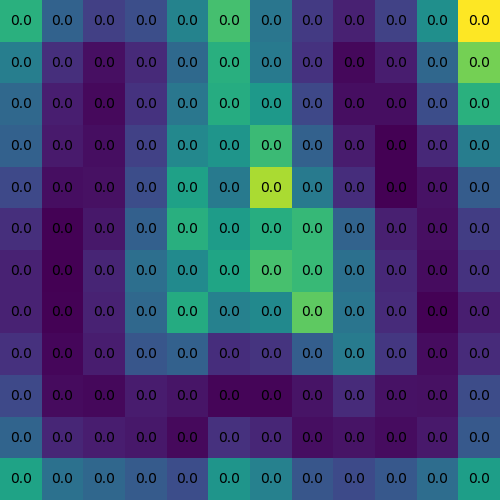

Figure 2D_traversal_latent_error_13_14 saved as {'png'}


<IPython.core.display.Javascript object>


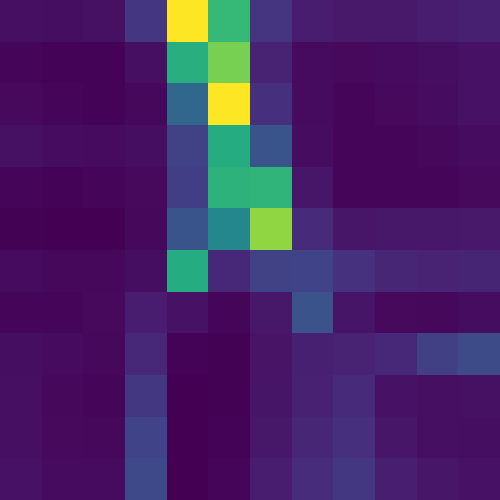

Figure 2D_traversal_image_error_13_14 saved as {'png'}


<IPython.core.display.Javascript object>


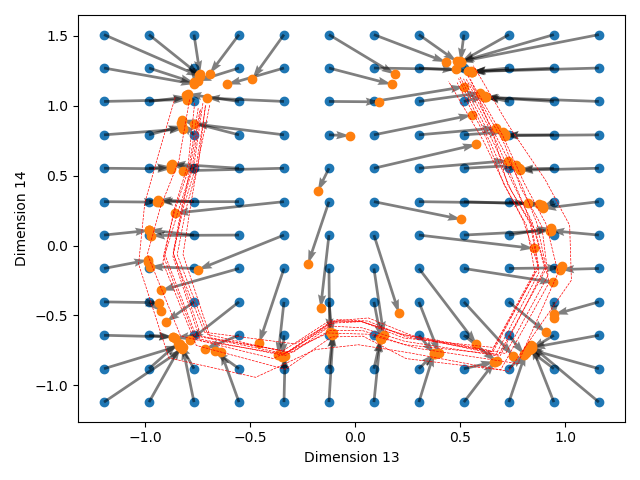

Figure 2D_traversal_projection_factor5_13_14 saved as {'png'}


In [120]:
if ix is not None and iy is not None:
    n = 12
    h, w = n, n

    mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
    mn, mx = mn.view(-1), mx.view(-1)

    cx, cy = torch.meshgrid(torch.linspace(mn[ix],mx[ix],h), torch.linspace(mn[iy],mx[iy],h))
    cx = cx.reshape(-1)
    cy = cy.reshape(-1)

    vecs = q.expand(len(cx), q.size(0)).contiguous()
    vecs[:, ix] = cx
    vecs[:, iy] = cy

    with torch.no_grad():
        x = model.decode(vecs)
    # x = x.view(h,w,*x.shape[1:])
        r,qr = model(x, ret_q=True)
        if isinstance(qr, distrib.Distribution):
            qr = qr.loc
    latent_losses = F.mse_loss(vecs,qr, reduction='none').view(x.shape[0],-1).mean(-1).view(h,w)
    img_losses = F.mse_loss(x,r, reduction='none').view(x.shape[0],-1).mean(-1).view(h,w)
    
    C, H, W = x.shape[-3:]
    x = x.cpu().numpy().reshape(h,w,C,H,W).transpose(1,0,2,3,4)[::-1].reshape(h*w,C,H,W)
    r = r.cpu().numpy().reshape(h,w,C,H,W).transpose(1,0,2,3,4)[::-1].reshape(h*w,C,H,W)
    #.reshape(h,w,*x.shape[1:]).permute(1,0,2,3,4).reshape(-1,*x.shape[1:]).cpu().numpy()
#     r = r.reshape(h,w,*x.shape[1:]).permute(1,0,2,3,4).reshape(-1,*x.shape[1:]).cpu().numpy()
    
    util.plot_imgs(x,H=h,W=w);
    util.save_figure(f'2D_traversal_{ix}_{iy}', root=figure_dir);
    
    util.plot_imgs(r,H=h,W=w);
    util.save_figure(f'2D_traversal_recovery_{ix}_{iy}', root=figure_dir);
    
    util.plot_mat(latent_losses.t().cpu().numpy()[::-1], val_fmt=1, figsize=(5,5));
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    util.save_figure(f'2D_traversal_latent_error_{ix}_{iy}', root=figure_dir);
    
    util.plot_mat(img_losses.t().cpu().numpy()[::-1], figsize=(5,5));
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    util.save_figure(f'2D_traversal_image_error_{ix}_{iy}', root=figure_dir);
    
    start, end = vecs.cpu().t()[[ix,iy]], qr.cpu().t()[[ix,iy]]

    plt.figure()
    plt.scatter(*start)
    delta = end - start
    # sel = slice(0,-1)
    plt.quiver(*start, *delta,angles='xy', scale_units='xy', scale=1, lw=0.5, alpha=0.5)
    plt.scatter(*end)
    plt.xlabel(f'Dimension {ix}')
    plt.ylabel(f'Dimension {iy}')
    
    inv_imgs = torch.stack([sampler.full_intervention(factor_dim) for _ in range(10)])
    B, N, C, H, W = inv_imgs.shape
    with torch.no_grad():
        int_q = model.encode(inv_imgs.to(device).view(B*N,C,H,W))
        if isinstance(int_q, distrib.Distribution):
            int_q = int_q.loc
        int_q = int_q.view(B, N, -1).cpu()
    plt.plot(*int_q[...,[ix,iy]].permute(2,1,0), c='r', ls='--', lw=0.5);
    plt.tight_layout()
    util.save_figure(f'2D_traversal_projection_factor{factor_dim}_{ix}_{iy}', root=figure_dir);